In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv("./어벤져스.txt", engine='python',encoding='utf-8', header=None, names=["title", "score", "review", "date"])
data = data[data.review.notnull()]
data = data.drop_duplicates()

In [4]:
from collections import defaultdict
from konlpy.tag import Komoran

ma = Komoran()

documents = defaultdict(list)
vocabulary = list()

for i, review in zip(data.index, data.review):
    for term in [_ for _ in ma.nouns(review) if 1 < len(_) < 8]:
        documents[i].append(term)
        vocabulary.extend(documents[i])
        
vocabulary = list(set(vocabulary))

In [5]:
from random import random

def getTheta(topic, docName):
    return docTopicDistribution[docName][topic] + a

def getPhi(term, topic):
    return (topicTermDistribution[topic][term] + b) / (topicTermCount[topic] + V * b)

def topicAssignment(docName, term, topic):
    return getTheta(topic, docName) * getPhi(term, topic)

def collapsedGibbsSampling(docName, term):
    return randomSampling([topicAssignment(docName, term, topic) for topic in range(K)])

def randomSampling(topicProbabilites):
    topicSum = sum(topicProbabilites)
    
    rnd = topicSum * random()

    for i, p in enumerate(topicProbabilites):
        rnd -= p
        
        if rnd <= 0:
            return i

In [6]:
K = 6

M = len(documents)
V = len(vocabulary)

a = 1.0
b = 0.1

docTermCount = defaultdict(int)
topicTermCount = defaultdict(int)
docTopicDistribution = defaultdict(lambda: defaultdict(int))
topicTermDistribution = defaultdict(lambda: defaultdict(int))
termTopicAssignmentMatrix = defaultdict(lambda: defaultdict(int))

In [7]:
from random import randrange

for docName, termList in documents.items():
    for termIdx, term in enumerate(termList):
        topic = randrange(K)
        
        docTermCount[docName] += 1
        topicTermCount[topic] += 1
        docTopicDistribution[docName][topic] += 1
        topicTermDistribution[topic][term] += 1
        
        termTopicAssignmentMatrix[docName][termIdx] = topic

In [8]:
iteration = 1000

for _ in range(iteration):
    for docName, termList in documents.items():
        for termIdx, term in enumerate(termList):
            topic = termTopicAssignmentMatrix[docName][termIdx]
            
            docTermCount[docName] -= 1
            topicTermCount[topic] -= 1
            docTopicDistribution[docName][topic] -= 1
            topicTermDistribution[topic][term] -= 1
            
            topic = collapsedGibbsSampling(docName, term)
            termTopicAssignmentMatrix[docName][termIdx] = topic
            
            docTermCount[docName] += 1
            topicTermCount[topic] += 1
            docTopicDistribution[docName][topic] += 1
            topicTermDistribution[topic][term] += 1
            
    if _%100 == 0:
        print("{0:2.0f}%".format(_/10))

 0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

path = "/Libray/Fonts/AppleGothic.ttf"

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["font.family"] = "AppleGothic"

def drawCloud(words, title):
    wc = WordCloud(font_path=path, max_words=30, background_color="white")
    wc.generate_from_frequencies(words)
    plt.imshow(wc.to_array())
    plt.title(title)
    plt.axis("off")
    plt.show()

In [11]:
topicTitle = ["캐릭터", "스토리", "감상평", "극장(환경)", "시리즈", "헌정(팬심)"]

for topic in range(K):
    topicWords = sorted(topicTermDistribution[topic].items(), key=lambda x:x[1], reverse=True)[:20]
    print(topicWords)
    drawCloud(dict(topicWords), topicTitle[topic])

[('아이언맨', 2), ('마블', 1), ('보세', 1), ('영화', 0), ('No.1', 0), ('You', 0), ('닥터스', 0), ('트레인', 0), ('저가', 0), ('전편', 0), ('기억', 0), ('세번', 0), ('마지막', 0), ('완벽', 0), ('완결', 0), ('시작', 0), ('감사', 0), ('10년', 0), ('동안', 0), ('시간', 0)]


OSError: cannot open resource

In [12]:
TDM = defaultdict(lambda: defaultdict(int))

for docName, termList in documents.items():
    for term in termList:
        TDM[term][docName] += 1

In [13]:
from math import log

pSeeds = ["감사", "완벽", "행복"]
nSeeds = ["화장실", "실망", "후회"]

N = len(documents)
smoothing = 0.1

positivePMI = defaultdict(lambda: defaultdict(float))
positiveNPMI = defaultdict(lambda: defaultdict(float))

negativePMI = defaultdict(lambda: defaultdict(float))
negativeNPMI = defaultdict(lambda: defaultdict(float))

for seed in pSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        positivePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        positiveNPMI[term][seed] = positivePMI[term][seed]/-log(jointLikelihood)
        

for seed in nSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        negativePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        negativeNPMI[term][seed] = negativePMI[term][seed]/-log(jointLikelihood)

ZeroDivisionError: float division by zero

In [14]:
pmiSO = defaultdict(float)
npmiSO = defaultdict(float)

for term in vocabulary:
    positivePmiSum = 0.0
    positiveNpmiSum = 0.0
    
    negativePmiSum = 0.0
    negativeNpmiSum = 0.0    
    
    for seed in pSeeds:
        positivePmiSum += positivePMI[term][seed]
        positiveNpmiSum += positiveNPMI[term][seed]
        
    for seed in nSeeds:
        negativePmiSum += negativePMI[term][seed]
        negativeNpmiSum += negativeNPMI[term][seed]
        
    pmiSO[term] = positivePmiSum - negativePmiSum
    npmiSO[term] = positiveNpmiSum - negativeNpmiSum

In [15]:
positivePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

positiveNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativeNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

drawCloud(positivePmiList, "")
drawCloud(negativePmiList, "")

OSError: cannot open resource

In [16]:
topicDistribution = list(0 for _ in range(K))

for docName, topicList in docTopicDistribution.items():
    sortedTopicList = sorted(topicList.items(), key=lambda x:x[1], reverse=True)
    try:
        topicDistribution[sortedTopicList[0][0]] += 1
    except:
        print(docName, topicList, sortedTopicList)

In [17]:
docTopicDistribution[15551391].items()
sorted(docTopicDistribution[15551391].items(), key=lambda x:x[1], reverse=True)[0]

IndexError: list index out of range

캐릭터 41.07276360893357 20.395414544296095
스토리 41.07276360893355 20.39541454429609
감상평 41.072763608933556 20.395414544296095
극장(환경) 41.072763608933556 20.395414544296088
시리즈 41.07276360893357 20.395414544296095
헌정(팬심) 41.07276360893357 20.3954145442961


C:\Users\brsta\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


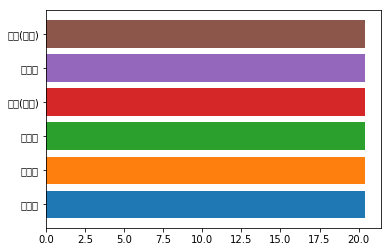

In [18]:
topicTitle = ["캐릭터", "스토리", "감상평", "극장(환경)", "시리즈", "헌정(팬심)"]

for topic in range(K):
    sentimentPMI = 0.0
    sentimentNPMI = 0.0
    
    topicWords = sorted(topicTermDistribution[topic].items(), key=lambda x:x[1], reverse=True)[:40]
    
    for term in topicWords:
        sentimentPMI += pmiSO[term[0]]
        sentimentNPMI += npmiSO[term[0]]
        
    print(topicTitle[topic], sentimentPMI, sentimentNPMI)
    plt.barh(topicTitle[topic], sentimentNPMI)
plt.show()